In [1]:
import yfinance as yf
from backtest_engine import BacktestEngine
from MACD_GoldX import macd_goldx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def fix_yf_columns(df):
    """
    Ensures DataFrame columns are flat and standard for single-ticker yfinance downloads.
    """
    # If columns are MultiIndex, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        # Try to get the second level (ticker name) if present
        if '' in df.columns.get_level_values(0):
            # Sometimes the first level is empty string
            df.columns = df.columns.get_level_values(1)
        else:
            # Otherwise, use the first level
            df.columns = df.columns.get_level_values(0)
    # Remove any leading/trailing whitespace from column names
    df.columns = [str(col).strip() for col in df.columns]
    return df

In [3]:
import sys
print(sys.executable)

/Users/metomatt/Documents/vscode/.venv/bin/python


In [ ]:
import ccxt
import pandas as pd
import time

exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1m'
since = exchange.parse8601('2023-01-01T00:00:00Z')  # Start date
all_ohlcv = []

while True:
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
    if not ohlcv:
        break
    all_ohlcv += ohlcv
    since = ohlcv[-1][0] + 60 * 1000  # Next minute
    time.sleep(0.5)  # Avoid rate limits

# Convert to DataFrame
df = pd.DataFrame(all_ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
df = df.set_index('Date')
df = df.drop('Timestamp', axis=1)
print(df.head())

In [63]:
btc = yf.download("BTC-USD", start="2022-01-01")
btc = btc.dropna()
btc = fix_yf_columns(btc)
print(btc.columns)  # Should show: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [39]:
engine = BacktestEngine(btc, macd_goldx)
result = engine.run()
result.head()



/Users/metomatt/Documents/vscode/subject001/MACD_GoldX.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Signal'].fillna(0, inplace=True)


,Close,High,Low,Open,Volume,MACD,MACDSignal,ATR,Signal,Position,Return,StrategyReturn,CumulativeReturn,CumulativeMarket
Date,,,,,,,,,,,,,,
2022-01-01,47686.812500,47827.312500,46288.484375,46311.746094,24582667004,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2022-01-02,47345.218750,47881.406250,46856.937500,47680.925781,27951569547,NaN,NaN,NaN,0.0,0.0,-0.007163,-0.0,1.0,0.992837
2022-01-03,46458.117188,47510.726562,45835.964844,47343.542969,33071628362,NaN,NaN,NaN,0.0,0.0,-0.018737,-0.0,1.0,0.974234
2022-01-04,45897.574219,47406.546875,45752.464844,46458.851562,42494677905,NaN,NaN,NaN,0.0,0.0,-0.012066,-0.0,1.0,0.962479
2022-01-05,43569.003906,46929.046875,42798.222656,45899.359375,36851084859,NaN,NaN,NaN,0.0,0.0,-0.050734,-0.0,1.0,0.913649


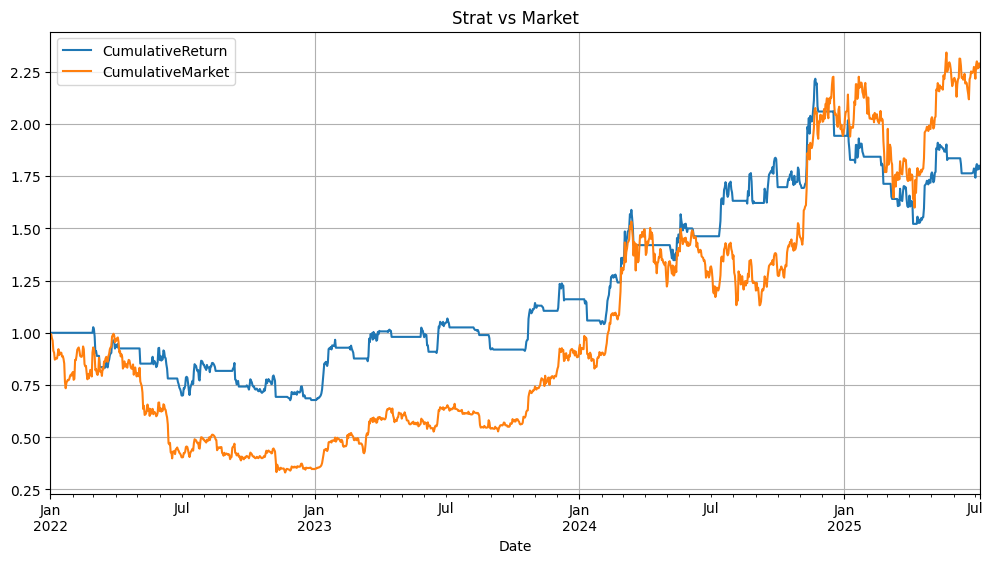

Win Rate: 0.2134
Annual Return: 0.1514
Sharpe Ratio: 0.5506
Max Drawdown: -0.3407


In [40]:
engine.plot()
metrics = engine.evaluate()
for k, v in metrics.items():
    print(f"{k}: {v}")

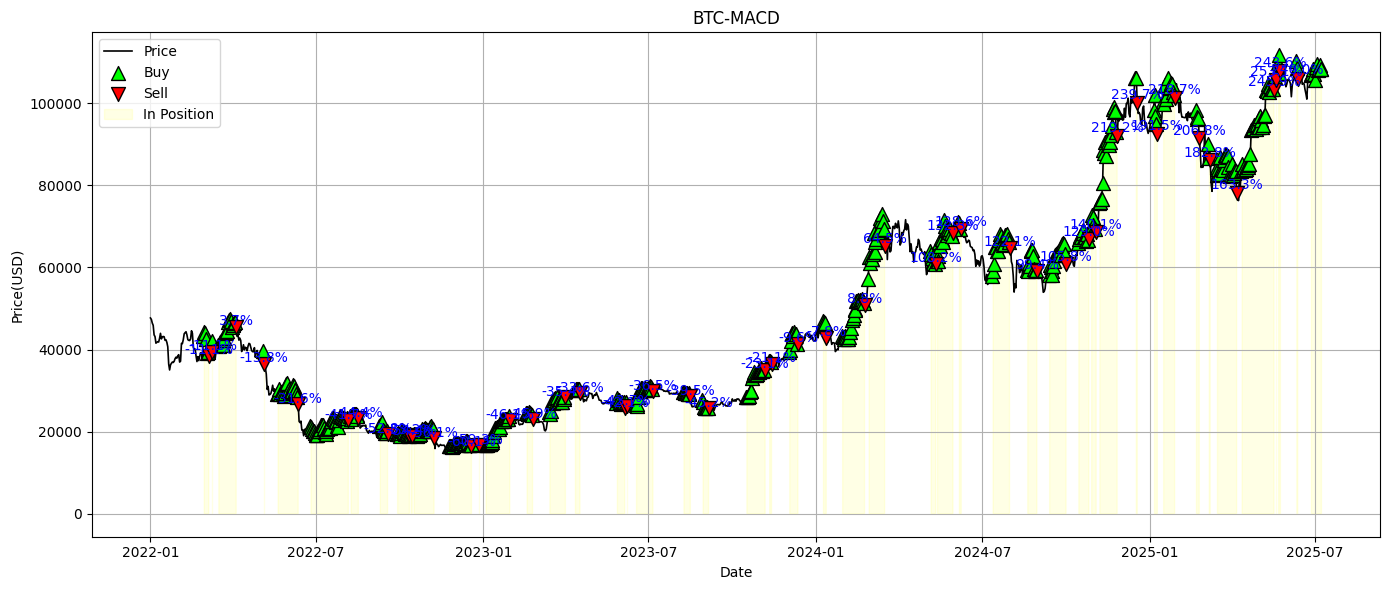

In [52]:
plt.figure(figsize=(14, 6))
plt.plot(result.index, result['Close'], label='Price', color='black', linewidth=1.2)
buy_indices = result.index[result['Signal'] == 1]
sell_indices = result.index[(result['Signal'] == 0) & (result['Signal'].shift(1) == 1)]
plt.scatter(buy_indices, result.loc[buy_indices, 'Close'], marker='^', color='lime', s=100, label='Buy', edgecolor='black', zorder=3)
plt.scatter(sell_indices, result.loc[sell_indices, 'Close'], marker='v', color='red', s=100, label='Sell', edgecolor='black', zorder=3)

in_position = result['Position'] == 1
plt.fill_between(result.index, result['Close'], where=in_position, color='yellow', alpha=0.1, label='In Position')

for buy_time, sell_time in zip(buy_indices, sell_indices):
    entry_price = result.loc[buy_time, 'Close']
    exit_price = result.loc[sell_time, 'Close']
    return_pct = (exit_price / entry_price - 1) * 100
    plt.text(sell_time, exit_price * 1.01, f"{return_pct:.1f}%", color='blue', fontsize=10, ha='center')

plt.title("BTC-MACD")
plt.xlabel("Date")
plt.ylabel("Price(USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
import pandas as pd
from IPython.display import display

# Find buy and sell indices
buy_indices = result[(result['Signal'].shift(1) == 0) & (result['Signal'] == 1)].index
sell_indices = result[(result['Signal'].shift(1) == 1) & (result['Signal'] == 0)].index

# Align buy/sell pairs
if len(sell_indices) > 0 and (len(buy_indices) == 0 or sell_indices[0] < buy_indices[0]):
    sell_indices = sell_indices[1:]
if len(buy_indices) > len(sell_indices):
    buy_indices = buy_indices[:-1]

trade_log = []
for buy_time, sell_time in zip(buy_indices, sell_indices):
    buy_price = result.loc[buy_time, 'Close']
    sell_price = result.loc[sell_time, 'Close']
    profit = sell_price - buy_price
    profit_pct = (sell_price / buy_price - 1) * 100

    trade_log.append({
        'Type': 'Buy',
        'Date': buy_time.strftime('%Y-%m-%d'),
        'Price': f"${buy_price:.2f}",
        'Profit/Loss': ''
    })
    trade_log.append({
        'Type': 'Sell',
        'Date': sell_time.strftime('%Y-%m-%d'),
        'Price': f"${sell_price:.2f}",
        'Profit/Loss': f"{profit:+.2f} ({profit_pct:+.2f}%)"
    })

df_trades = pd.DataFrame(trade_log)

# Styling function
def highlight_row(row):
    styles = [''] * len(row)
    if row['Type'] == 'Buy':
        styles[0] = 'background-color: #228B22; color: white;'  # Type
        styles[1] = 'background-color: #228B22; color: white;'  # Date
        styles[2] = 'background-color: #228B22; color: white;'  # Price
    elif row['Type'] == 'Sell':
        styles[0] = 'background-color: #B22222; color: white;'
        styles[1] = 'background-color: #B22222; color: white;'
        styles[2] = 'background-color: #B22222; color: white;'
        # Profit/Loss cell
        if row['Profit/Loss'].startswith('-'):
            styles[3] = 'background-color: #B22222; color: white;'
        else:
            styles[3] = 'background-color: #228B22; color: white;'
    return styles

styled = df_trades.style.apply(highlight_row, axis=1)
display(styled)

,Type,Date,Price,Profit/Loss
0,Buy,2022-02-28,$43193.23,
1,Sell,2022-03-06,$38419.98,-4773.25 (-11.05%)
2,Buy,2022-03-09,$41982.93,
3,Sell,2022-03-10,$39437.46,-2545.46 (-6.06%)
4,Buy,2022-03-16,$41143.93,
5,Sell,2022-04-05,$45555.99,+4412.06 (+10.72%)
6,Buy,2022-05-04,$39698.37,
7,Sell,2022-05-05,$36575.14,-3123.23 (-7.87%)
8,Buy,2022-05-20,$29200.74,
9,Sell,2022-06-12,$26762.65,-2438.09 (-8.35%)
